# Importing

In [1]:
import string
import nltk
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, LatentDirichletAllocation

from nltk.corpus import stopwords
from nltk import word_tokenize, RegexpTokenizer, TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
# nltk.download('punkt')

from matplotlib import cm
from imblearn.over_sampling import ADASYN
from gensim.models.word2vec import Word2Vec

pd.set_option('max_colwidth', None)

In [28]:
df = pd.read_excel('twitterdata.xlsx', sheet_name='Tweet')
userid = pd.read_excel('twitterdata.xlsx', sheet_name='User')
df.head()

,TweetID,Weekday,Hour,Day,Lang,IsReshare,Reach,RetweetCount,Likes,Klout,Sentiment,text,LocationID,UserID
0,tw-682712873332805633,Thursday,17.0,31.0,en,0.0,44.0,0.0,0.0,35.0,0.0,We are hiring: Senior Software Engineer - Proto http://www.reqcloud.com/jobs/719865/?k=0LaPxXuFwczs1e32ZURJKrgCIDMQtRO7BquFSQthUKY&utm_source=twitter&utm_campaign=reqCloud_JobPost #job @awscloud #job #protocol #networking #aws #mediastreaming,3751.0,tw-40932430
1,tw-682713045357998080,Thursday,17.0,31.0,en,1.0,1810.0,5.0,0.0,53.0,2.0,RT @CodeMineStatus: This is true Amazon Web Services https://aws.amazon.com/ #php #html #html5 #css #webdesign #seo #java #javascript htt,3989.0,tw-3179389829
2,tw-682713219375476736,Thursday,17.0,31.0,en,0.0,282.0,0.0,0.0,47.0,0.0,Devops Engineer Aws Ansible Cassandra Mysql Ubuntu Ruby On Rails Jobs in Austin TX #Austin #TX #jobs #jobsearch https://www.jobfindly.com/devops-engineer-aws-ansible-cassandra-mysql-ubuntu-ruby-on-rails-jobs-austin-tx.html,3741.0,tw-4624808414
3,tw-682713436967579648,Thursday,17.0,31.0,en,0.0,2087.0,4.0,0.0,53.0,0.0,Happy New Year to all those AWS instances of ours!,3753.0,tw-356447127
4,tw-682714048199311366,Thursday,17.0,31.0,en,0.0,953.0,0.0,0.0,47.0,0.0,Amazon is hiring! #Sr. #International Tax Manager - AWS in #Seattle apply now! #jobs http://neuvoo.com/job.php?id=dsvkrujig3&source=twitter&lang=en&client_id=658&l=Seattle%20Washington%20US&k=Sr.%20International%20Tax%20Manager%20-%20AWS http://twitter.com/NeuvooAccSea/status/682714048199311366/photo/1,3751.0,tw-3172686669


# Cleaning

In [29]:
# Re-naming so they are more manageable

df.columns = ['tweetid', 'weekday', 'hour', 'day', 'lang', 'isreshare', 'reach', 'retweetcount', 'likes', 'klout', 'sentiment', 'text', 'locationid', 'userid']

In [30]:
# Majority of tweets are in english.

df = df[df['lang'] == 'en']

In [31]:
# We want to only work with a few sentiment values.

df['sentiment'].value_counts(normalize=True).head(15)

 0.000000    0.667838
 1.000000    0.094933
 2.000000    0.093115
 3.000000    0.041715
-1.000000    0.019176
-2.000000    0.018686
 1.500000    0.012624
 4.000000    0.008663
 2.500000    0.007520
 0.500000    0.005844
-3.000000    0.005333
-0.500000    0.002971
-1.500000    0.002427
-4.000000    0.002318
 2.666667    0.001741
Name: sentiment, dtype: float64

In [32]:
# Removing null values as they mess up code

df.dropna(inplace=True)
df.drop_duplicates(inplace=True, subset=['text'])

In [33]:
df['sentiment'].value_counts(normalize=True).head(15)

 0.000000    0.665653
 2.000000    0.092047
 1.000000    0.088318
 3.000000    0.043855
-1.000000    0.021467
-2.000000    0.020515
 1.500000    0.013230
 4.000000    0.009766
 2.500000    0.008019
-3.000000    0.006334
 0.500000    0.005741
-0.500000    0.003682
-1.500000    0.002621
-4.000000    0.002247
 1.666667    0.001732
Name: sentiment, dtype: float64

In [34]:
# Removing rows that do not have the values we want.

sentimentlist = [0.0, 1.0, 2.0, 3.0, -1.0, -2.0]
df = df.loc[df.sentiment.isin(sentimentlist)]

In [35]:
df['sentiment'].value_counts(normalize=True)

 0.0    0.714331
 2.0    0.098778
 1.0    0.094776
 3.0    0.047062
-1.0    0.023037
-2.0    0.022016
Name: sentiment, dtype: float64

# Getting Links

We want to remove links from the tweets to make it easier to tokenize the actual tweets. However we want to keep the links, should they exist for a tweet.

In [10]:
df['links'] = df['text'].str.findall(r'(http\S+)')

In [11]:
df['username'] = df['text'].str.findall(r'(@\S+)')
df['hashtags'] = df['text'].str.findall(r'(#\S+)')
df.head()

,tweetid,weekday,hour,day,lang,isreshare,reach,retweetcount,likes,klout,sentiment,text,locationid,userid,links,username,hashtags
0,tw-682712873332805633,Thursday,17.0,31.0,en,0.0,44.0,0.0,0.0,35.0,0.0,We are hiring: Senior Software Engineer - Proto http://www.reqcloud.com/jobs/719865/?k=0LaPxXuFwczs1e32ZURJKrgCIDMQtRO7BquFSQthUKY&utm_source=twitter&utm_campaign=reqCloud_JobPost #job @awscloud #job #protocol #networking #aws #mediastreaming,3751.0,tw-40932430,[http://www.reqcloud.com/jobs/719865/?k=0LaPxXuFwczs1e32ZURJKrgCIDMQtRO7BquFSQthUKY&utm_source=twitter&utm_campaign=reqCloud_JobPost],[@awscloud],"[#job, #job, #protocol, #networking, #aws, #mediastreaming]"
1,tw-682713045357998080,Thursday,17.0,31.0,en,1.0,1810.0,5.0,0.0,53.0,2.0,RT @CodeMineStatus: This is true Amazon Web Services https://aws.amazon.com/ #php #html #html5 #css #webdesign #seo #java #javascript htt,3989.0,tw-3179389829,[https://aws.amazon.com/],[@CodeMineStatus:],"[#php, #html, #html5, #css, #webdesign, #seo, #java, #javascript]"
2,tw-682713219375476736,Thursday,17.0,31.0,en,0.0,282.0,0.0,0.0,47.0,0.0,Devops Engineer Aws Ansible Cassandra Mysql Ubuntu Ruby On Rails Jobs in Austin TX #Austin #TX #jobs #jobsearch https://www.jobfindly.com/devops-engineer-aws-ansible-cassandra-mysql-ubuntu-ruby-on-rails-jobs-austin-tx.html,3741.0,tw-4624808414,[https://www.jobfindly.com/devops-engineer-aws-ansible-cassandra-mysql-ubuntu-ruby-on-rails-jobs-austin-tx.html],[],"[#Austin, #TX, #jobs, #jobsearch]"
3,tw-682713436967579648,Thursday,17.0,31.0,en,0.0,2087.0,4.0,0.0,53.0,0.0,Happy New Year to all those AWS instances of ours!,3753.0,tw-356447127,[],[],[]
4,tw-682714048199311366,Thursday,17.0,31.0,en,0.0,953.0,0.0,0.0,47.0,0.0,Amazon is hiring! #Sr. #International Tax Manager - AWS in #Seattle apply now! #jobs http://neuvoo.com/job.php?id=dsvkrujig3&source=twitter&lang=en&client_id=658&l=Seattle%20Washington%20US&k=Sr.%20International%20Tax%20Manager%20-%20AWS http://twitter.com/NeuvooAccSea/status/682714048199311366/photo/1,3751.0,tw-3172686669,"[http://neuvoo.com/job.php?id=dsvkrujig3&source=twitter&lang=en&client_id=658&l=Seattle%20Washington%20US&k=Sr.%20International%20Tax%20Manager%20-%20AWS, http://twitter.com/NeuvooAccSea/status/682714048199311366/photo/1]",[],"[#Sr., #International, #Seattle, #jobs]"


# Tokenizing

In [12]:
stopwords_list = stopwords.words('english')
stopwords_list += ['aws', 'rt', 'amazon', 'awscloud', 'cloud']

In [13]:
tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)
lem = WordNetLemmatizer()

In [14]:
def clean_tweets(tweets_list, lemmatizer=None, tokenizer=None, stopwords_list=None):  
    data = []
    for tweet in tweets_list:
        t = []
        tweet = tokenizer.tokenize(tweet)
        for i in tweet:
            i = i.strip('#')
            i = lemmatizer.lemmatize(i)
            if i.isalnum() == True and i not in stopwords_list:
                t.append(i)
        data.append(t)
    return data

df['data'] = clean_tweets(df['text'], lem, tokenizer, stopwords_list)

In [15]:
df['data']

0                           [hiring, senior, software, engineer, proto, job, job, protocol, networking, mediastreaming]
1                                     [true, web, service, php, html, html5, cs, webdesign, seo, java, javascript, htt]
2        [devops, engineer, ansible, cassandra, mysql, ubuntu, ruby, rail, job, austin, tx, austin, tx, job, jobsearch]
3                                                                                          [happy, new, year, instance]
4                                                        [hiring, sr, international, tax, manager, seattle, apply, job]
                                                              ...                                                      
99991                      [added, video, playlist, module, 1, understanding, auto, recovery, high, availabilty, using]
99992                                     [added, video, playlist, module, 4, cloudwatch, monitoring, handson, session]
99993                                   

In [16]:
df['strings'] = [' '.join(i) for i in df['data']]

In [17]:
df['strings']

0                      hiring senior software engineer proto job job protocol networking mediastreaming
1                                  true web service php html html5 cs webdesign seo java javascript htt
2        devops engineer ansible cassandra mysql ubuntu ruby rail job austin tx austin tx job jobsearch
3                                                                               happy new year instance
4                                                 hiring sr international tax manager seattle apply job
                                                      ...                                              
99991                  added video playlist module 1 understanding auto recovery high availabilty using
99992                               added video playlist module 4 cloudwatch monitoring handson session
99993                                 added video playlist module 2 cloudwatch monitoring certification
99996                     added video playlist module 3 ec2 inst

In [18]:
alldata = [item for elem in df['data'] for item in elem]
alldata

['hiring',
 'senior',
 'software',
 'engineer',
 'proto',
 'job',
 'job',
 'protocol',
 'networking',
 'mediastreaming',
 'true',
 'web',
 'service',
 'php',
 'html',
 'html5',
 'cs',
 'webdesign',
 'seo',
 'java',
 'javascript',
 'htt',
 'devops',
 'engineer',
 'ansible',
 'cassandra',
 'mysql',
 'ubuntu',
 'ruby',
 'rail',
 'job',
 'austin',
 'tx',
 'austin',
 'tx',
 'job',
 'jobsearch',
 'happy',
 'new',
 'year',
 'instance',
 'hiring',
 'sr',
 'international',
 'tax',
 'manager',
 'seattle',
 'apply',
 'job',
 'bc',
 'limit',
 'test',
 'prod',
 'isolated',
 'region',
 'else',
 'dev',
 'could',
 'impact',
 'prod',
 'lambda',
 'beyond',
 'isolating',
 'dev',
 'prod',
 'envs',
 'like',
 'difficult',
 'bc',
 'service',
 'availability',
 'really',
 'good',
 'way',
 'around',
 'problem',
 'isolation',
 'account',
 'level',
 'would',
 'work',
 'alludes',
 'pg',
 '17',
 'make',
 'identity',
 'management',
 'difficult',
 'red',
 'line',
 'v',
 'green',
 'line',
 'reporting',
 'vital',
 'res

In [19]:
word_set = list(set(alldata))

In [20]:
word_set.sort()

In [21]:
word_set

['0',
 '00',
 '000',
 '00012887',
 '00017123421',
 '004',
 '0045',
 '00824ffaa70',
 '00http',
 '01',
 '01233',
 '01494618764',
 '015',
 '01803',
 '01m13s',
 '020116au',
 '02081663888',
 '021416au',
 '021416tw',
 '022',
 '022d0',
 '03',
 '030716au',
 '030716tw',
 '032816au',
 '03582',
 '039',
 '03aa',
 '0487',
 '04c912d08f0',
 '04ik8y',
 '05d4603e067',
 '0600',
 '073',
 '07508811304',
 '07738846689',
 '079',
 '079698http',
 '09',
 '09062',
 '0915hrs',
 '09386756',
 '0a1',
 '0a12',
 '0a3',
 '0a4',
 '0a5',
 '0aws',
 '0b19987e',
 '0da',
 '0e45',
 '0e607',
 '0ee9c',
 '0f',
 '0fee3',
 '0o3kk',
 '0vt6nl',
 '0x01',
 '0xe4c5',
 '1',
 '10',
 '100',
 '1000',
 '1000location',
 '1000th',
 '1000v',
 '1000x',
 '1001',
 '100b',
 '100gb',
 '100k',
 '100kpa',
 '100m',
 '100mb',
 '100million',
 '100usd',
 '100x',
 '100yrs',
 '101',
 '1015',
 '1016',
 '1017',
 '102km',
 '103',
 '105',
 '106',
 '10634',
 '106room',
 '107',
 '109',
 '109th',
 '10a5b',
 '10am',
 '10b',
 '10bln',
 '10bn',
 '10daystilteam',
 '

In [22]:
print(len(df['data']))
print(len(alldata))

59730
471000


In [23]:
total_vocab = []
for word in alldata:
    if word not in total_vocab:
        total_vocab.append(word)
len(total_vocab)

24487

In [24]:
data_freqdist = FreqDist(alldata)
data_freqdist.most_common(20)

[('service', 9338),
 ('job', 8356),
 ('web', 6217),
 ('new', 4436),
 ('engineer', 3919),
 ('lambda', 3497),
 ('hiring', 3266),
 ('azure', 3211),
 ('google', 2969),
 ('data', 2863),
 ('via', 2644),
 ('devops', 2631),
 ('using', 2217),
 ('wa', 2152),
 ('software', 2002),
 ('manager', 1958),
 ('blog', 1855),
 ('security', 1841),
 ('developer', 1812),
 ('free', 1801)]

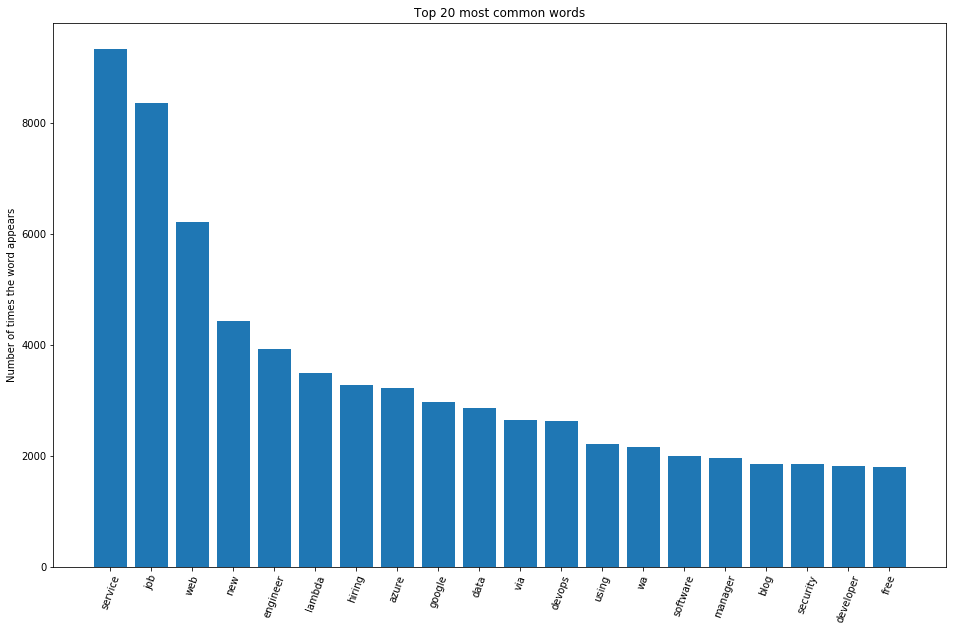

In [25]:
mostcommonwords20 = data_freqdist.most_common(20)

plt.figure(figsize=(16, 10))
plt.bar(range(len(mostcommonwords20)), [val[1] for val in mostcommonwords20], align='center')
plt.xticks(range(len(mostcommonwords20)), [val[0] for val in mostcommonwords20])
plt.xticks(rotation=70)
plt.ylabel('Number of times the word appears')
plt.title('Top 20 most common words')
plt.show()

# EDA for all sentiment types

In [26]:
dfsent0 = df[df['sentiment'] == 0.0]

datasent0 = clean_tweets(dfsent0['text'], lem, tokenizer)

alldatasent0 = [item for elem in datasent0 for item in elem]

data_freqdistsent0 = FreqDist(alldatasent0)
data_freqdistsent0.most_common(20)

TypeError: argument of type 'NoneType' is not iterable

In [ ]:
mostcommonwords20sent0 = data_freqdistsent0.most_common(20)

plt.figure(figsize=(16, 10))
plt.bar(range(len(mostcommonwords20sent0)), [val[1] for val in mostcommonwords20sent0], align='center')
plt.xticks(range(len(mostcommonwords20sent0)), [val[0] for val in mostcommonwords20sent0])
plt.xticks(rotation=70)
plt.ylabel('Number of times the word appears')
plt.title('Top 20 most common words for Sentiment 0')
plt.show()

In [ ]:
dfsent1 = df.loc[df['sentiment'] == 1.0]

datasent1 = clean_tweets(dfsent1['text'], lem, tokenizer)

alldatasent1 = [item for elem in datasent1 for item in elem]

data_freqdistsent1 = FreqDist(alldatasent1)
data_freqdistsent1.most_common(20)

In [ ]:
mostcommonwords20sent1 = data_freqdistsent1.most_common(20)

plt.figure(figsize=(16, 10))
plt.bar(range(len(mostcommonwords20sent1)), [val[1] for val in mostcommonwords20sent1], align='center')
plt.xticks(range(len(mostcommonwords20sent1)), [val[0] for val in mostcommonwords20sent1])
plt.xticks(rotation=70)
plt.ylabel('Number of times the word appears')
plt.title('Top 20 most common words for Sentiment 1')
plt.show()

In [ ]:
dfsent2 = df.loc[df['sentiment'] == 2.0]

datasent2 = clean_tweets(dfsent2['text'], lem, tokenizer)

alldatasent2 = [item for elem in datasent2 for item in elem]

data_freqdistsent2 = FreqDist(alldatasent2)
data_freqdistsent2.most_common(20)

In [ ]:
mostcommonwords20sent2 = data_freqdistsent2.most_common(20)

plt.figure(figsize=(16, 10))
plt.bar(range(len(mostcommonwords20sent2)), [val[1] for val in mostcommonwords20sent2], align='center')
plt.xticks(range(len(mostcommonwords20sent2)), [val[0] for val in mostcommonwords20sent2])
plt.xticks(rotation=70)
plt.ylabel('Number of times the word appears')
plt.title('Top 20 most common words for Sentiment 2')
plt.show()

In [ ]:
dfsent3 = df.loc[df['sentiment'] == 3.0]

datasent3 = clean_tweets(dfsent3['text'], lem, tokenizer)

alldatasent3 = [item for elem in datasent3 for item in elem]

data_freqdistsent3 = FreqDist(alldatasent3)
data_freqdistsent3.most_common(20)

In [ ]:
mostcommonwords20sent3 = data_freqdistsent3.most_common(20)

plt.figure(figsize=(16, 10))
plt.bar(range(len(mostcommonwords20sent3)), [val[1] for val in mostcommonwords20sent3], align='center')
plt.xticks(range(len(mostcommonwords20sent3)), [val[0] for val in mostcommonwords20sent3])
plt.xticks(rotation=70)
plt.ylabel('Number of times the word appears')
plt.title('Top 20 most common words for Sentiment 3')
plt.show()

In [ ]:
dfsentneg1 = df.loc[df['sentiment'] == -1.0]

datasentneg1 = clean_tweets(dfsentneg1['text'], lem, tokenizer)

alldatasentneg1 = [item for elem in datasentneg1 for item in elem]

data_freqdistsentneg1 = FreqDist(alldatasentneg1)
data_freqdistsentneg1.most_common(20)

In [ ]:
mostcommonwords20sentneg1 = data_freqdistsentneg1.most_common(20)

plt.figure(figsize=(16, 10))
plt.bar(range(len(mostcommonwords20sentneg1)), [val[1] for val in mostcommonwords20sentneg1], align='center')
plt.xticks(range(len(mostcommonwords20sentneg1)), [val[0] for val in mostcommonwords20sentneg1])
plt.xticks(rotation=70)
plt.ylabel('Number of times the word appears')
plt.title('Top 20 most common words for Sentiment -1')
plt.show()

In [ ]:
dfsentneg2 = df.loc[df['sentiment'] == -2.0]

datasentneg2 = clean_tweets(dfsentneg2['text'], lem, tokenizer)

alldatasentneg2 = [item for elem in datasentneg2 for item in elem]

data_freqdistsentneg2 = FreqDist(alldatasentneg2)
data_freqdistsentneg2.most_common(20)

In [ ]:
mostcommonwords20sentneg2 = data_freqdistsentneg2.most_common(20)

plt.figure(figsize=(16, 10))
plt.bar(range(len(mostcommonwords20sentneg2)), [val[1] for val in mostcommonwords20sentneg2], align='center')
plt.xticks(range(len(mostcommonwords20sentneg2)), [val[0] for val in mostcommonwords20sentneg2])
plt.xticks(rotation=70)
plt.ylabel('Number of times the word appears')
plt.title('Top 20 most common words for Sentiment -2')
plt.show()

In [ ]:
gender = userid.to_dict()
df['gender'] = df['userid'].map(gender['Gender'])
genders = {'Female':2, 'Male':1, 'Unisex':3, 'Unknown':0}
df['gender'] = df['gender'].map(genders)

weekdays = {'Sunday':1, 'Monday':2, 'Tuesday':3, 'Wednesday':4, 'Thursday':5, 'Friday':6, 'Saturday':7}
df['weekday'] = df['weekday'].map(weekdays)

In [ ]:
# df['link'] = np.where(df['links']==True, 1,0)

In [ ]:
df.head()

In [ ]:
X = df.drop(columns = ['sentiment', 'lang', 'tweetid', 'text', 'userid', 'links'])
y = df['sentiment']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
X_train_text = X_train['data']
X_test_text = X_test['data']

In [ ]:
scaler = StandardScaler()
tfidf_vec = TfidfVectorizer(stop_words = stopwords_list, ngram_range=(2, 2))
c_vec = CountVectorizer(stop_words= stopwords_list)
pca = PCA(random_state=5)
lda = LatentDirichletAllocation(n_components=5, random_state=10)
w2v = Word2Vec(workers=10)

In [ ]:
tf_idf_train = tfidf_vec.fit_transform(X_train_text)
tf_idf_test = tfidf_vec.transform(X_test_text)

c_train = c_vec.fit_transform(X_train_text)
c_test = c_vec.transform(X_test_text)

# w2v_train = w2v(X_train_text)

In [ ]:
# tfidf_train_scaled = scaler.fit_transform(tf_idf_train.todense())
# tfidf_test_scaled = scaler.fit(tf_idf_test.todense())

# c_train_scaled = scaler.fit(c_train.todense())
# c_test_scaled = scaler.fit(c_test.todense())

In [ ]:
dfsent1.head(20)

In [ ]:
df['text'].nunique()